In [2]:
import numpy as np
import scipy
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import plotnine as p9
import matplotlib.pyplot as plt

from functools import partial

The gravity model is likely one of the most important and empirically successful theories in modern economics. In some sense one could consider it the „fundamental law“ of economic geography. It is also (in my experience) mostly unknown outside academia, especially compared to some other theories which have far less empirical support. 

Say we want to describe the trade flows (denominated in terms of their value in some currency) between different countries (or cities, or any other geographic entity). Taking the point of view of a particular country, the gravity model asserts that:

- It will trade more with big and rich countries (i.e. countries with a large total GDP) than with poorer and smaller countries 
- It will trade more with close neighbors and less with far-away countries

The gravity model stands in direct opposition to very optimistic ideas that globalization and digitalization have made the world "flat". And while we will discuss it only in relation to trade patterns, it can equally be applied to migration, commuting and any other flow of people, goods or even ideas. 

## Formalization of a simple gravity model

Let us formalize the idea of the gravity model.

In notation, we have:

$t_{ij} = C \frac{G_i G_j}{D_{ij}}$

where:

- $t_{ij}$ is the trade flow between country i and contry j
- $G_i$: is the GDP (expressed in some fixed currency) of country i
- $D_{ij}$ is the distance between country i and country j, in whatever unit
- $C$ is some constant

Usually, we want to allow a bit more freedom in the exact functional form of the relationship, so we add parameters $\alpha, \beta, \mu$:

$t_{ij} = C\frac{G_i^{\alpha} G_j^{\beta}}{D_{ij}^{\mu}}$

From there, the analogy of this theory with the concept of gravity from physics is more clear. The GDP of a country is like its mass: richer, bigger countries exert more of a „force“ that attracts trade. However, this attraction decays as a function of distance (for the analogy with gravity to be perfect, we would require $\alpha = 1, \beta = 1, \mu = 2$, but as we will see, this is generally not the case).

This being said, the functional form above is somewhat awkward to apply to real data, because it involves a division. It is much easier to take the log of both sides, which transforms it into a simple regression equation:

$\log t_{ij} = C + \alpha \log G_i + \beta \log G_j + \mu \log D_{ij} $

It is also important to note a few other things here:

- This formulation of gravity is symmetric, so it cannot generate unbalanced bilateral trade. In reality most countries have unbalanced trade overall and with all of their trading partners bilaterally. We will ignore this.
- In many scenarios, the best figure for GDP to use is the one computed using Purchasing Power Parity (PPP). Gravity is an exception: here, for once, we want the GDP in USD (or some other currency).

We can now test this model empirically. For this purpose, will use trade data from Germany from 2019 and try to predict German trade with other countries. In other words, we will estimate the model:

$\log t_{ij} = C + \beta \log G_j + \mu \log D_{j} $

where:

- $t_{j}$ is the exports from Germany to country j
- $D_{j}$ is the distance between Germany and country j, in whatever unit (we will use km)

**Note: As we will discuss later, this model is not the correct way to estimate a gravity equation as per the standards of modern economics.** It is a simplification and it omits some important variables. But, as we will see, it is in some ways "good enough".

## Empirical test: German trade in 2019

To perform our empirical test, we have to do some data crunching first. We already have World Bank data of trade and GDP in the Data folder. To compute the distances, we will use the geopandas example shape file with the countries of the world.

### Import data

In [23]:
world_path = geopandas.datasets.get_path('naturalearth_lowres')
world_df = geopandas.read_file(world_path)
# from World Bank
gdp_df = pd.read_csv("Data/Gravity/gdp_current_dollar.csv")
# from World Bank, WITS
trade_df = pd.read_csv("Data/Gravity/germany_trade.tsv",sep="\t")

### Compute centroids of each country

In [24]:
plt.rcParams["figure.figsize"] = (12,12)

If we use the geographical coordinates to compute centroids, the results will be slightly strange. This is because the geopandas centroid algorithm does not accont for the curvature of the earth. As a quick fix, we first project onto a flat map (using an area preserving projection, in this case CEA), then compute the centroids on this flat map, and then project back onto longitude/latitude.

<AxesSubplot: >

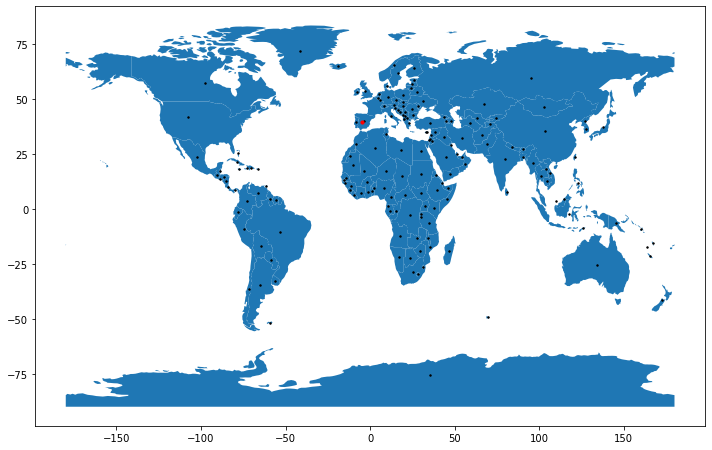

In [25]:
world_df["centroid"] = world_df.to_crs('+proj=cea').centroid.to_crs(world_df.crs)
# lets plot
ax = world_df["geometry"].plot()
world_df["centroid"].plot(ax=ax, color="black",markersize=2)
world_df.query('name == "France"')["centroid"].plot(ax=ax, color="red",markersize=10)

We see that some centroids looks strange. This likely due to overseas territories (e.g. Hawaii for the US). For France (in red), this deviation is particularly visible. Because we will analyze German trade, France is somewhat important to get right, so we will manually fix this:

<AxesSubplot: >

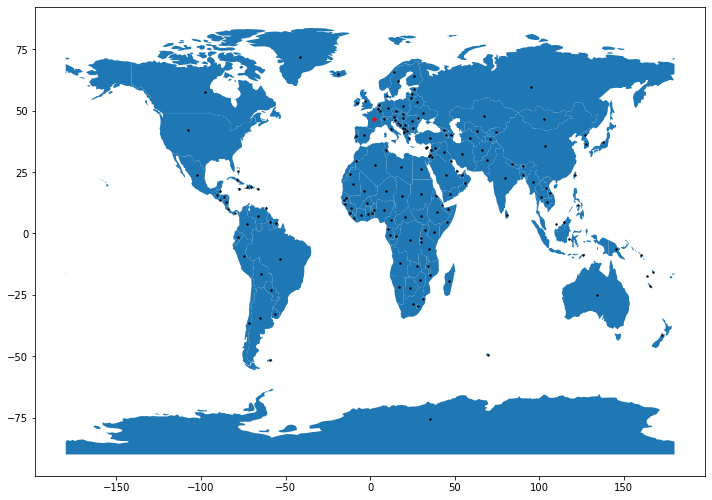

In [26]:
# First we select the right geometry (the one representing the french "mainland", i.e. the hexagone)
hexagone_poly = [x for x in world_df.query('name == "France"')["geometry"].iloc[0].geoms][1]
# We replace with this Polygon
fr_idx = world_df.query('name == "France"').index[0]
world_df.at[fr_idx, "geometry"] = hexagone_poly
# Now we recompute the centroids and replot
world_df["centroid"] = world_df.to_crs('+proj=cea').centroid.to_crs(world_df.crs)
# lets plot
ax = world_df["geometry"].plot()
world_df["centroid"].plot(ax=ax, color="black",markersize=2)
world_df.query('name == "France"')["centroid"].plot(ax=ax, color="red",markersize=10)

There are of course some other centroids which do not reflect reality very well. For example, the economic center of Russia (i.e. where most goods would flow to and come from) likely is located much closer to the west (soemwhere around moscow). The economic centers of the PRC and Brazil, meanwhile, should be much closer to their respective coastlines. 

### Compute the distance between centroids

We will compute the distance between centroids manually, using the great cricle distance. This assumes that the earth is a sphere, which is of course not the case. However, for what we are doing here, we do not need too much precision - the centroids are already a very rough approximation!

In [27]:
def great_circle_distance(lat1, lon1, lat2, lon2, radius = 6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    angle = np.arccos(np.sin(lat1)*np.sin(lat2) + np.cos(lat1)*np.cos(lat2)*np.cos(lon1 - lon2))
    return angle*radius

# Note that the centroid geometries have longitude in x and latitude in y
lon_ger = world_df.query('name == "Germany"')["centroid"].iloc[0].x
lat_ger = world_df.query('name == "Germany"')["centroid"].iloc[0].y
    
great_circle_germany = partial(great_circle_distance, lat_ger, lon_ger)

In [28]:
world_df["dist"] = world_df["centroid"].apply(lambda x: great_circle_germany(x.y, x.x))

### Merge with the gdp and trade data

In [110]:
# Compute total trade with Germany (Exports + Imports)
trade_df["trade"] = trade_df['Export (US$ Thousand)']
# Rename and merge
trade_df = trade_df.rename(columns={"Partner Name":"wb_name"})
gdp_df = gdp_df.rename(columns={"Country Name":"wb_name","2019 [YR2019]":"GDP", "Country Code":"iso_a3"})
merged_df = gdp_df[["wb_name","GDP","iso_a3"]].merge(world_df[["name","dist","iso_a3", "continent"]], on="iso_a3")
merged_df = trade_df[["wb_name","trade"]].merge(merged_df,on="wb_name")
# We have a few countries with unknown GDP, we remove those
merged_df = merged_df.query('GDP != ".."')
merged_df["GDP"] = merged_df["GDP"].astype("float")

### Log-scale and estimate the model

In many datasets, especially those concerning trade between smaller entities like regions or companies there might be flows of zero between some entities. These zeros are generally quite informative: a trade of zero implies that the costs of trading are higher than the benefits such trade would bring. However, if we log-scale, these zeros would have to be removed - which throws away useful information. In that case, a better model might be a poisson or zero-inflated poisson regression.

In our data, we have just assumed away the zeros because (1) our trade data only includes countries that actually trade with Germany and (2) we performed an inner join to merge the datasets, so we remove countries which are not on that list. We are left with 155 countries out of 195, which I will say is *good enough*.

In [111]:
merged_df["log_trade"] = np.log(merged_df["trade"])
merged_df["log_gdp"] = np.log(merged_df["GDP"])
merged_df["log_dist"] = np.log(merged_df["dist"])

In [100]:
gravity_model = smf.ols(formula='log_trade ~ log_gdp + log_dist', data=merged_df).fit()

### Analysing the results

As we fitted a simple linear regression, the easiest way to assess the goodness of fit is with the explained variance, i.e. the R-squared:

In [101]:
gravity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_trade   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     1095.
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           5.31e-91
Time:                        22:25:39   Log-Likelihood:                -163.76
No. Observations:                 155   AIC:                             333.5
Df Residuals:                     152   BIC:                             342.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8750      0.981     -5.991      0.000      -7.812      -3.938
log_gdp        1.1284      0.029     38.854      0.000       1.071       1.186
log_dist      -1.0689      0.063    -17.030      0.000      -1.193      -0.945
==============================================================================
Omnibus:                        7.561   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.977
Skew:                           0.397   Prob(JB):                       0.0185
Kurtosis:                       3.777   Cond. No.                         457.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

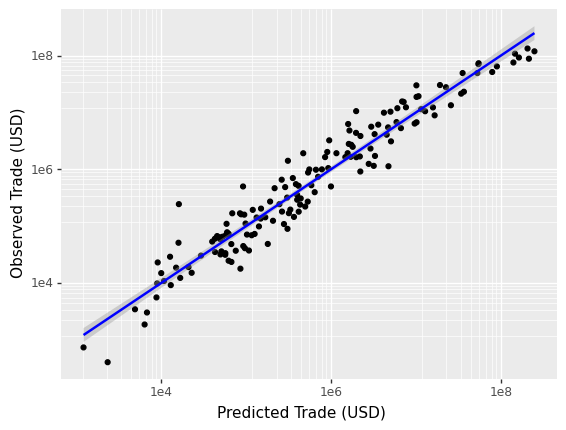

<ggplot: (8727214914030)>

In [103]:
preds = gravity_model.predict()
plot_df = pd.DataFrame({"Predicted Trade (USD)":np.exp(preds),"Observed Trade (USD)":merged_df["trade"]})

(p9.ggplot(data=plot_df,mapping=p9.aes(x="Predicted Trade (USD)", y= "Observed Trade (USD)"))
 + p9.geom_point()
 + p9.scale_x_log10()
 + p9.scale_y_log10()
 + p9.geom_smooth(color="blue", method="lm")
)

This is indeed a very good fit: 93.5% of variance in German exports can be predicted by a model with only two degrees of freedom. Pretty amazing!

Note also that the parameters are close to 1 for GDP and -1 for distance. So the best fitting model is close to the very simple unparametrized gravity - and the decay with distance is linear, not quadratic as it is for the physical force of gravity.

This being said, it is important to note that GDP is doing most of the work here: it alone will explain 81% of variance. However, if we only use GDP to predict trade, this will overpredict trade with far-away countries and underestimate trade with close neighbours:

In [104]:
gdp_model = smf.ols(formula='log_trade ~ log_gdp', data=merged_df).fit()
print(gdp_model.rsquared)
preds = gdp_model.predict()

0.8113032957730777


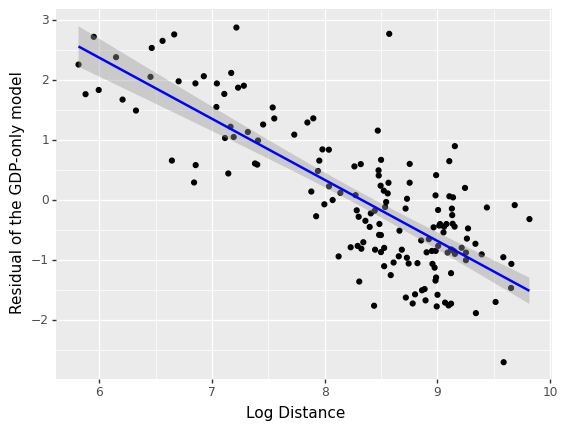

<ggplot: (8727214851051)>

In [105]:
residual = merged_df["log_trade"] - preds
merged_df["gdp_residual"] = residual

(p9.ggplot(data=merged_df,mapping=p9.aes(x="log_dist", y= "gdp_residual"))
 + p9.geom_point()
 + p9.geom_smooth(color="blue", method="lm")
 + p9.labs(x="Log Distance",y="Residual of the GDP-only model")
)

## Transportation costs rather than distance

In the simple formulation of gravity above, we simply assumed that trade decays with distance, and then found empirical support for this. But, of course, distance *itself* is not what hinders trade, but rather the cost of traversing distance. And this cost greatly depends on the precise geography between places.

For example, it is usually much cheaper (per km of distance travelled) to transport goods by sea or river, than it is by land. Meanwhile, mountains, swamps or desert generally will impede over-land transport, while thick ice will prevent (most) sea transport. Infrastructure can somewhat mitigate these costs - tunnels, for example, make mountains more navigable - but building such infrastructure is in itself very expensive, especially if the geography is unfavourable.

Beyond geography, distance can create other barriers. For example, trading with far-away places usually will imply trading with people who speak another langauge, use a different currency, a different legal system and other such factors. All of these can create trade costs.

We can explore this a bit in our data. Firstly, to test for things like legal and cultural barriers, we could ask for example whether Germany trades more with EU countries than distance and GDP alone would predict. 

In [106]:
EU = set(["AUT","BEL","BGR","HRV","CYP","CZE","DNK","EST","FIN","FRA","DEU","GRC","HUN","IRL",
"ITA","LVA","LTU","LUX","MLT","NLD","POL","PRT","ROU","SVK","SVN","ESP","SWE"])

merged_df["in_eu"] = merged_df['iso_a3'].apply(lambda x: x in EU)
europe_model = smf.ols(formula='log_trade ~ log_gdp + log_dist + in_eu', data=merged_df).fit()
europe_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_trade   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     754.3
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           1.25e-90
Time:                        22:25:58   Log-Likelihood:                -160.91
No. Observations:                 155   AIC:                             329.8
Df Residuals:                     151   BIC:                             342.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.9086      1.060     -6.520      0.000      -9.002      -4.815
in_eu[T.True]     0.5333      0.225      2.375      0.019       0.090       0.977
log_gdp           1.1163      0.029     38.422      0.000       1.059       1.174
log_dist         -0.9192      0.088    -10.411      0.000      -1.094      -0.745
==============================================================================
Omnibus:                        9.596   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.064
Skew:                           0.403   Prob(JB):                      0.00240
Kurtosis:                       4.104   Cond. No.                         504.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Indeed, it appears that adding EU membership as explanatory variable slightly improves the model. Interestingly, this "eats" some of the distance effect.

Given the reasoning above that sea transport is better than land transport, we would expect that a model using only distance and GDP would overpredict trade with landlocked countries. Let us examine this

In [113]:
landlocked = set(["Afghanistan","Armenia","Azerbaijan","Bhutan","Bolivia","Botswana","Burkina Faso","Burundi",
 "Central African Republic","Chad","Eswatini","Ethiopia","Kazakhstan","Kyrgyzstan","Laos",
 "Lesotho","North Macedonia","Malawi","Mali","Mongolia","Nepal","Niger","Paraguay","Moldova",
 "Rwanda","South Sudan","Tajikistan","Turkmenistan","Uganda","Uzbekistan","Zambia","Zimbabwe"])

merged_df["landlocked"] = merged_df['name'].apply(lambda x: x in landlocked)
landlock_model = smf.ols(formula='log_trade ~ log_gdp + log_dist + landlocked', data=merged_df).fit()
landlock_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_trade   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     744.3
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           3.21e-90
Time:                        22:27:32   Log-Likelihood:                -161.88
No. Observations:                 155   AIC:                             331.8
Df Residuals:                     151   BIC:                             343.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.4399      0.998     -5.450      0.000      -7.412      -3.468
landlocked[T.True]    -0.2942      0.153     -1.922      0.057      -0.597       0.008
log_gdp                1.1113      0.030     36.887      0.000       1.052       1.171
log_dist              -1.0638      0.062    -17.083      0.000      -1.187      -0.941
==============================================================================
Omnibus:                        7.056   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.185
Skew:                           0.392   Prob(JB):                       0.0275
Kurtosis:                       3.705   Cond. No.                         470.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that being landlocked appears to slightly decreases trade with Germany, but the effect is not statistically significant. A big issue with this estimation likely is that the fact of being landlocked is already reflected in the GDP:

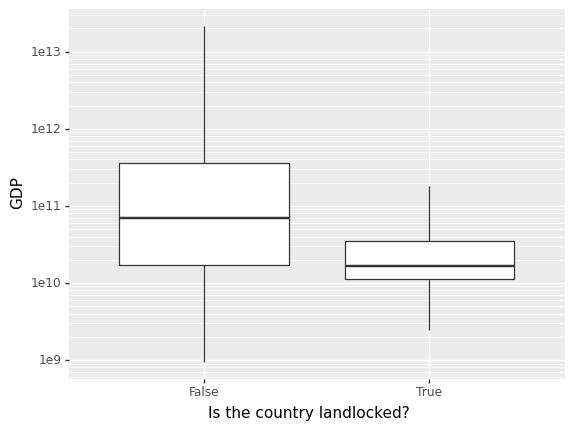

<ggplot: (8727215226025)>

In [115]:
(p9.ggplot(data=merged_df,mapping=p9.aes(x="landlocked", y= "GDP"))
 + p9.geom_boxplot()
 + p9.scale_y_log10()
 + p9.labs(x="Is the country landlocked?",y="GDP")
)

## Multilateral resistance

There is a much bigger problem with GDP. 

## "Universal" gravity and trade cost imputation